In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Data

In [2]:
N = 300

x = 2 * torch.rand(N) - 1
u = torch.sin(2 * x + 1) + 0.2 * torch.exp(1.3 * x)

train_x = x.unsqueeze(-1)
train_u = u.unsqueeze(-1)

# Single Stage Neural Network

In [3]:
import torch.nn as nn
import torch.nn.functional as nnF

model = nn.Sequential(
    nn.Linear(1, 30), nn.Tanh(),
    nn.Linear(30, 30), nn.Tanh(),
    nn.Linear(30, 30), nn.Tanh(),
    nn.Linear(30, 1)
)

iterations = 12000
optimizer = torch.optim.Adam(model.parameters())
train_loss_history = []

for iter in range(1, iterations):

    out = model(train_x)
    loss = nnF.mse_loss(train_u, out)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss_history.append(loss.item())

# Multi-stage Neural Network

## First Stage

In [4]:
model1 = nn.Sequential(
    nn.Linear(1, 20), nn.Tanh(),
    nn.Linear(20, 20), nn.Tanh(),
    nn.Linear(20, 20), nn.Tanh(),
    nn.Linear(20, 1)
)

iterations = 6000
optimizer1 = torch.optim.Adam(model1.parameters())
optimizer2 = torch.optim.LBFGS(model1.parameters())
train_loss_history1 = []
train_loss_history2 = []

def closure():
    optimizer2.zero_grad()
    out = model1(train_x)
    loss = nnF.mse_loss(train_u, out)
    loss.backward()
    return loss

for iter in range(1, iterations):

    if iter < 4000:
        out = model1(train_x)
        loss = nnF.mse_loss(train_u, out)
        loss.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        train_loss_history1.append(loss.item())
    
    else:
        
        loss = optimizer2.step(closure)
        train_loss_history2.append(loss.item())

In [5]:
with torch.no_grad():
    train_u_pred = model1(train_x)

train_e1 = train_u - train_u_pred
eps1 = torch.std(train_e1)
train_e1_normalized = train_e1/eps1

## Second Stage

In [6]:
model2 = nn.Sequential(
    nn.Linear(1, 20), nn.Tanh(),
    nn.Linear(20, 20), nn.Tanh(),
    nn.Linear(20, 20), nn.Tanh(),
    nn.Linear(20, 1)
)

iterations = 6000
optimizer1 = torch.optim.Adam(model2.parameters())
optimizer2 = torch.optim.LBFGS(model2.parameters())
train_loss_history3 = []
train_loss_history4 = []

def closure():
    optimizer2.zero_grad()
    out = model2(train_x)
    loss = nnF.mse_loss(train_e1_normalized, out)
    loss.backward()
    train_u_pred2 = train_u_pred + out * eps1
    return nnF.mse_loss(train_u, train_u_pred2).item()

for iter in range(1, iterations):

    if iter < 4000:

        out = model2(train_x)
        loss = nnF.mse_loss(train_e1_normalized, out)
        loss.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        train_u_pred2 = train_u_pred + out * eps1
        train_loss_history3.append(nnF.mse_loss(train_u, train_u_pred2).item())

    else:

        loss = optimizer2.step(closure)
        train_loss_history4.append(loss)

In [7]:
with torch.no_grad():
    train_e1_pred = eps1 * model2(train_x)

train_u_pred2 = train_u_pred + train_e1_pred
train_e2 = train_u - train_u_pred2

# Comparison of Models

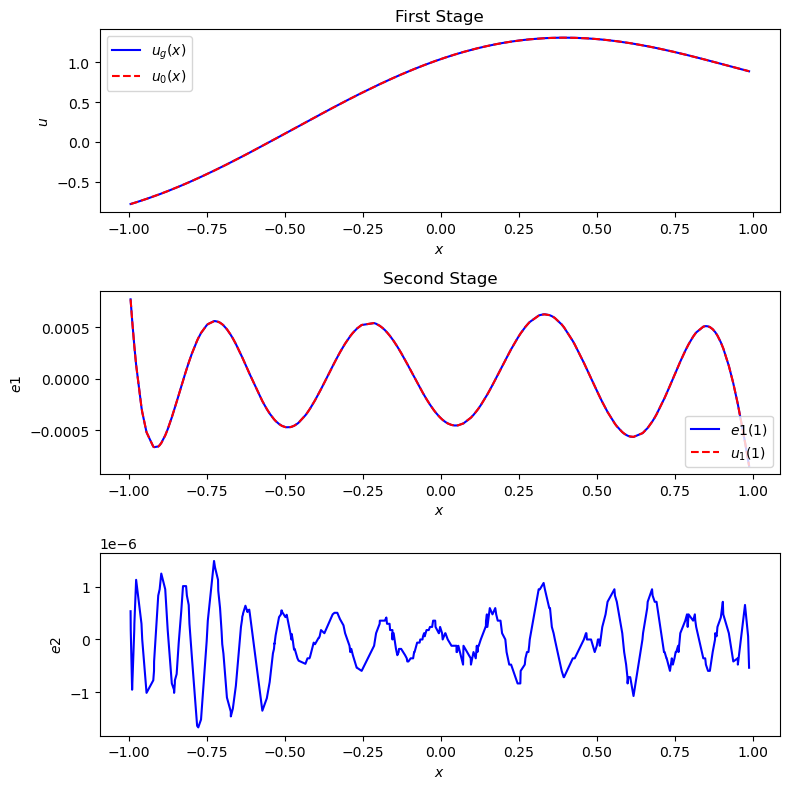

In [8]:
sorted_idx = torch.argsort(train_x.flatten())

fig = plt.figure(figsize=(8, 8))
ax = fig.subplots(3, 1)

ax[0].plot(train_x.flatten()[sorted_idx], train_u.flatten()[sorted_idx], "b", label=r"$u_g(x)$")
ax[0].plot(train_x.flatten()[sorted_idx], train_u_pred.flatten()[sorted_idx], "r--", label=r"$u_0(x)$")
ax[0].set_title("First Stage")
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$u$")
ax[0].legend(loc="best")

ax[1].plot(train_x.flatten()[sorted_idx], train_e1.flatten()[sorted_idx], "b", label=r"$e1(1)$")
ax[1].plot(train_x.flatten()[sorted_idx], train_e1_pred.flatten()[sorted_idx], "r--", label=r"$u_1(1)$")
ax[1].set_title("Second Stage")
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$e1$")
ax[1].legend(loc="best")

ax[2].plot(train_x.flatten()[sorted_idx], train_e2.flatten()[sorted_idx], "b")
ax[2].set_xlabel(r"$x$")
ax[2].set_ylabel(r"$e2$")

fig.tight_layout()

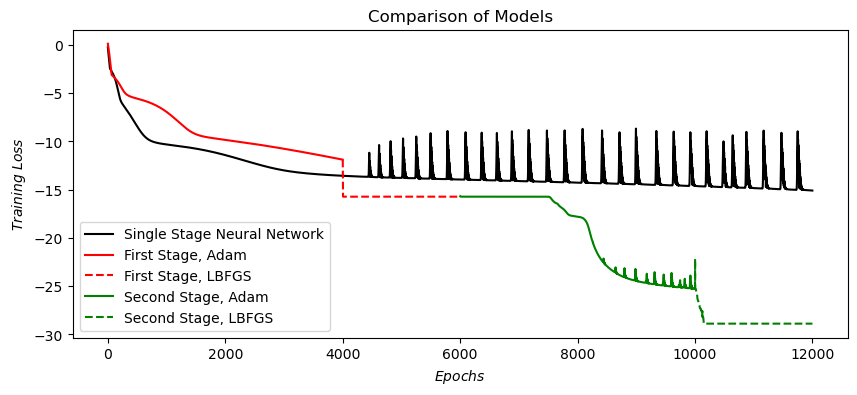

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(np.log(train_loss_history), color="black", label="Single Stage Neural Network")
plt.plot(np.log(train_loss_history1), "r", label="First Stage, Adam")
plt.plot(range(4000, 6000), np.log(train_loss_history2), "r--", label="First Stage, LBFGS")
plt.plot(range(6000, 9999), np.log(train_loss_history3), "g", label="Second Stage, Adam")
plt.plot(range(10000, 12000), np.log(train_loss_history4), "g--", label="Second Stage, LBFGS")
plt.title("Comparison of Models")
plt.xlabel(r"$Epochs$")
plt.ylabel(r"$Training\ Loss$")
plt.legend(loc="best")